# Exploratory Data Analysis (EDA)

In [2]:
!pip install openTSNE

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif , SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import seaborn as sns
import os

current_path = os.getcwd()

In [4]:
data_path = os.path.join(current_path, "data", "phase2", "train.csv")
df = pd.read_csv(data_path)
df = pl.from_pandas(df)

In [5]:
"""
Id: Unique identifier for each row in the test set.
flow_time: Duration of network flow.
header_size: Size of the packet headers.
packet_duration: Duration of individual packets.
overall_rate: Overall data transfer rate.
src_rate: Data transfer rate from the source.
dst_rate: Data transfer rate towards the destination.
fin_packets: Number of packets flagged as finished (FIN).
urg_packets: Number of urgent packets (URG).
rst_packets: Number of reset packets (RST).
max_value: Maximum value observed in packet data.
syn_flags: Number of SYN (synchronize) flags detected.
rst_flags: Number of RST (reset) flags detected.
psh_flags: Number of PSH (push) flags detected.
ack_flags: Number of ACK (acknowledge) flags detected.
protocol_http: Indicates HTTP protocol usage.
protocol_https: Indicates HTTPS protocol usage.
protocol_tcp: Indicates TCP protocol usage.
protocol_udp: Indicates UDP protocol usage.
protocol_icmp: Indicates ICMP protocol usage.
label (only in train.csv): Type of cyber-attack to be predicted (e.g., DDoS, DoS, benign).
"""
df.schema

Schema([('flow_time', Float64),
        ('header_size', Float64),
        ('packet_duration', Float64),
        ('overall_rate', Float64),
        ('src_rate', Float64),
        ('dst_rate', Float64),
        ('fin_packets', Float64),
        ('urg_packets', Float64),
        ('rst_packets', Float64),
        ('max_value', Float64),
        ('value_covariance', Float64),
        ('fin_flags', Int64),
        ('syn_flags', Int64),
        ('rst_flags', Int64),
        ('psh_flags', Int64),
        ('ack_flags', Int64),
        ('protocol_http', Int64),
        ('protocol_https', Int64),
        ('protocol_tcp', Int64),
        ('protocol_udp', Int64),
        ('protocol_icmp', Int64),
        ('label', String)])

In [6]:
df.describe()

statistic,flow_time,header_size,packet_duration,overall_rate,src_rate,dst_rate,fin_packets,urg_packets,rst_packets,max_value,value_covariance,fin_flags,syn_flags,rst_flags,psh_flags,ack_flags,protocol_http,protocol_https,protocol_tcp,protocol_udp,protocol_icmp,label
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""count""",938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,938583.0,"""938583"""
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0"""
"""mean""",13.42515,101813.423375,82.664589,9163.49561,9163.49561,0.000002,0.099474,5.850813,37.137514,177.16136,29689.164549,0.087102,0.208346,0.091149,0.088415,0.121502,0.048001,0.054196,0.574175,0.21141,0.164314,null
"""std""",5898.098733,1.8014e6,166.986325,100180.600226,100180.600226,0.000898,0.299712,70.715367,324.61358,515.425327,356901.659348,0.281984,0.406126,0.287821,0.283898,0.32671,0.213769,0.226403,0.494468,0.408309,0.37056,null
"""min""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""BenignTraffic"""
"""25%""",0.0,54.0,64.0,2.077074,2.077074,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null
"""50%""",0.0,54.0,64.0,15.703769,15.703769,0.0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,null
"""75%""",0.101755,364.0,64.0,117.774989,117.774989,0.0,0.0,0.0,0.01,55.14,1.184216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,null
"""max""",4.9301e6,3.3111737e8,6525.74,7.340032e6,7.340032e6,0.848465,19.5,4136.7,9331.5,30329.2,1.3728e8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,"""Recon"""


In [7]:
# how may classes do we have?
print(df["label"].unique().value_counts().sum()["count"][0] ," unique labels")
df = df.with_columns(pl.col("label").str.to_lowercase()) # case folding , expression object: pl.col("label")

# Are the classes unbalanced
quickOVERVIEW = df["label"].value_counts().with_columns((pl.col("count")/df["label"].shape[0] *100).alias("percentage"))
quickOVERVIEW

6  unique labels


label,count,percentage
str,u32,f64
"""dos""",163428,17.412205
"""benigntraffic""",21987,2.342574
"""ddos""",687027,73.198321
"""recon""",6433,0.685395
"""mirai""",53395,5.688895
"""mitm""",6313,0.67261


<BarContainer object of 6 artists>

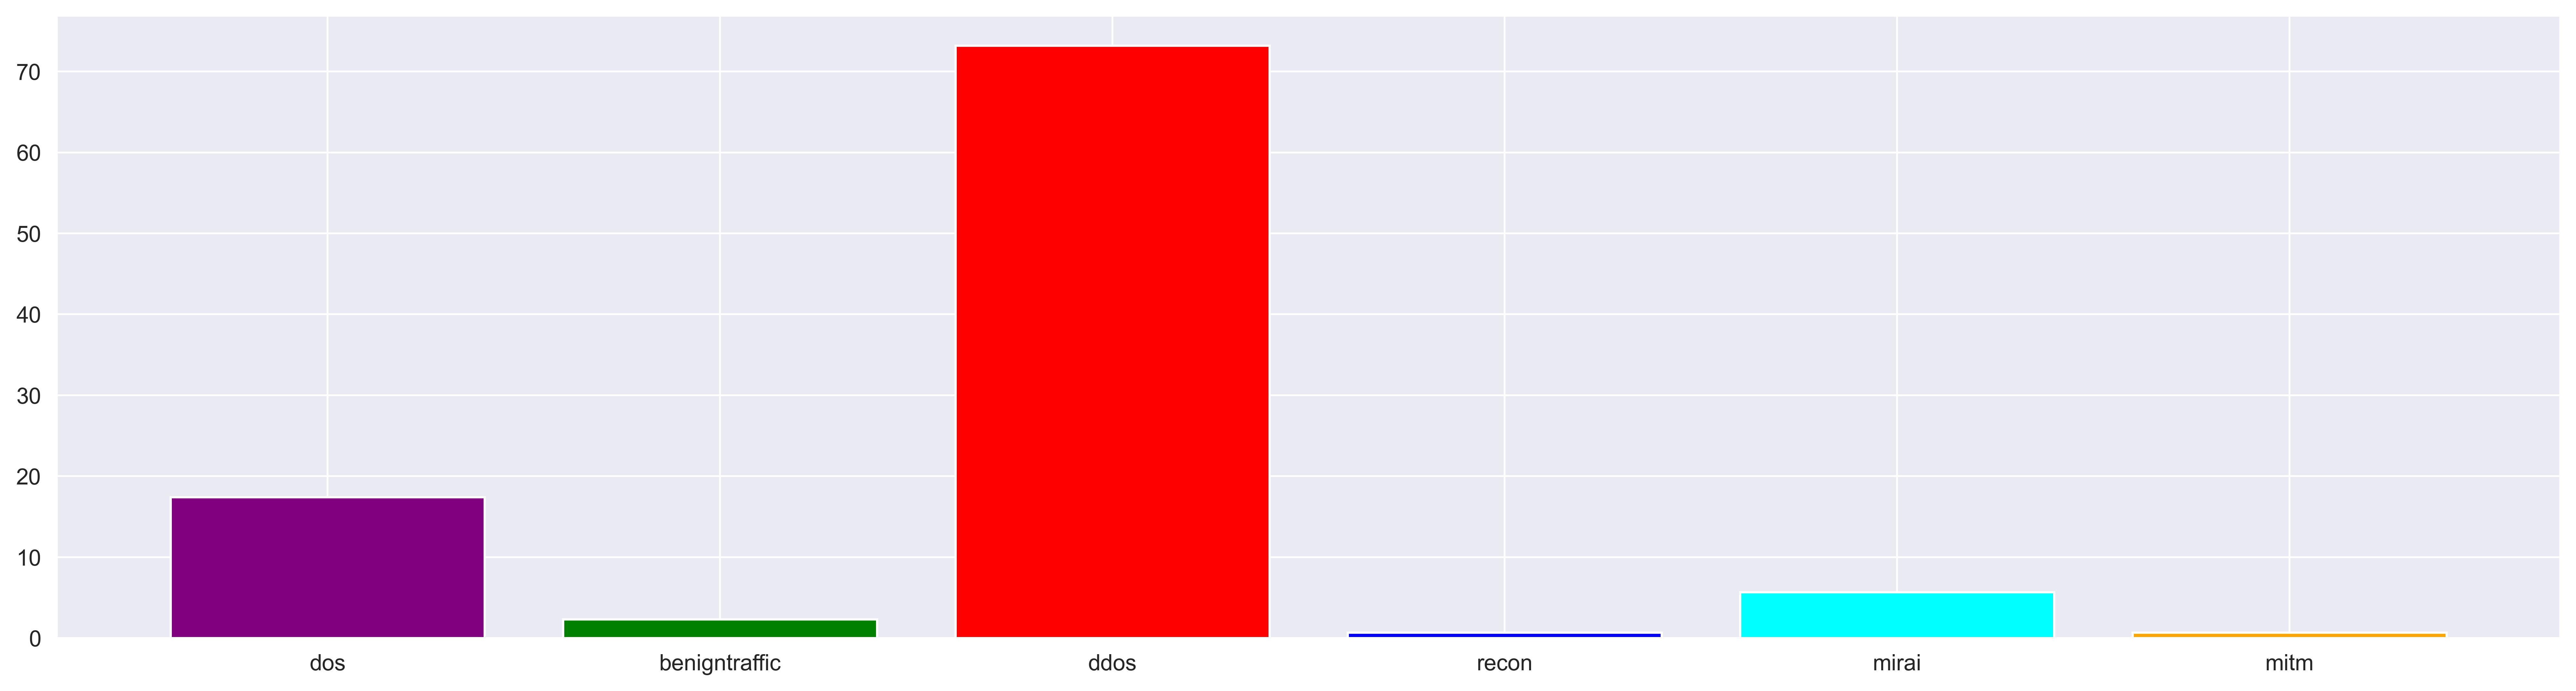

In [8]:
plt.figure(figsize=(20, 5), dpi=500)
plt.bar(
    quickOVERVIEW["label"], 
    height=quickOVERVIEW["percentage"] , 
    color= quickOVERVIEW["label"].replace({
    "ddos": "red",             
    "recon": "blue",           
    "benigntraffic": "green", 
    "mitm": "orange",          
    "dos": "purple",          
    "mirai": "cyan"           
}
))

In [10]:
profile = ProfileReport(df.to_pandas(), title="Profiling Report" , explorative=True , lazy= True , minimal = True)
# Display the report (Kaggle should automatically render it)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 22/22 [00:02<00:00,  8.92it/s][A


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

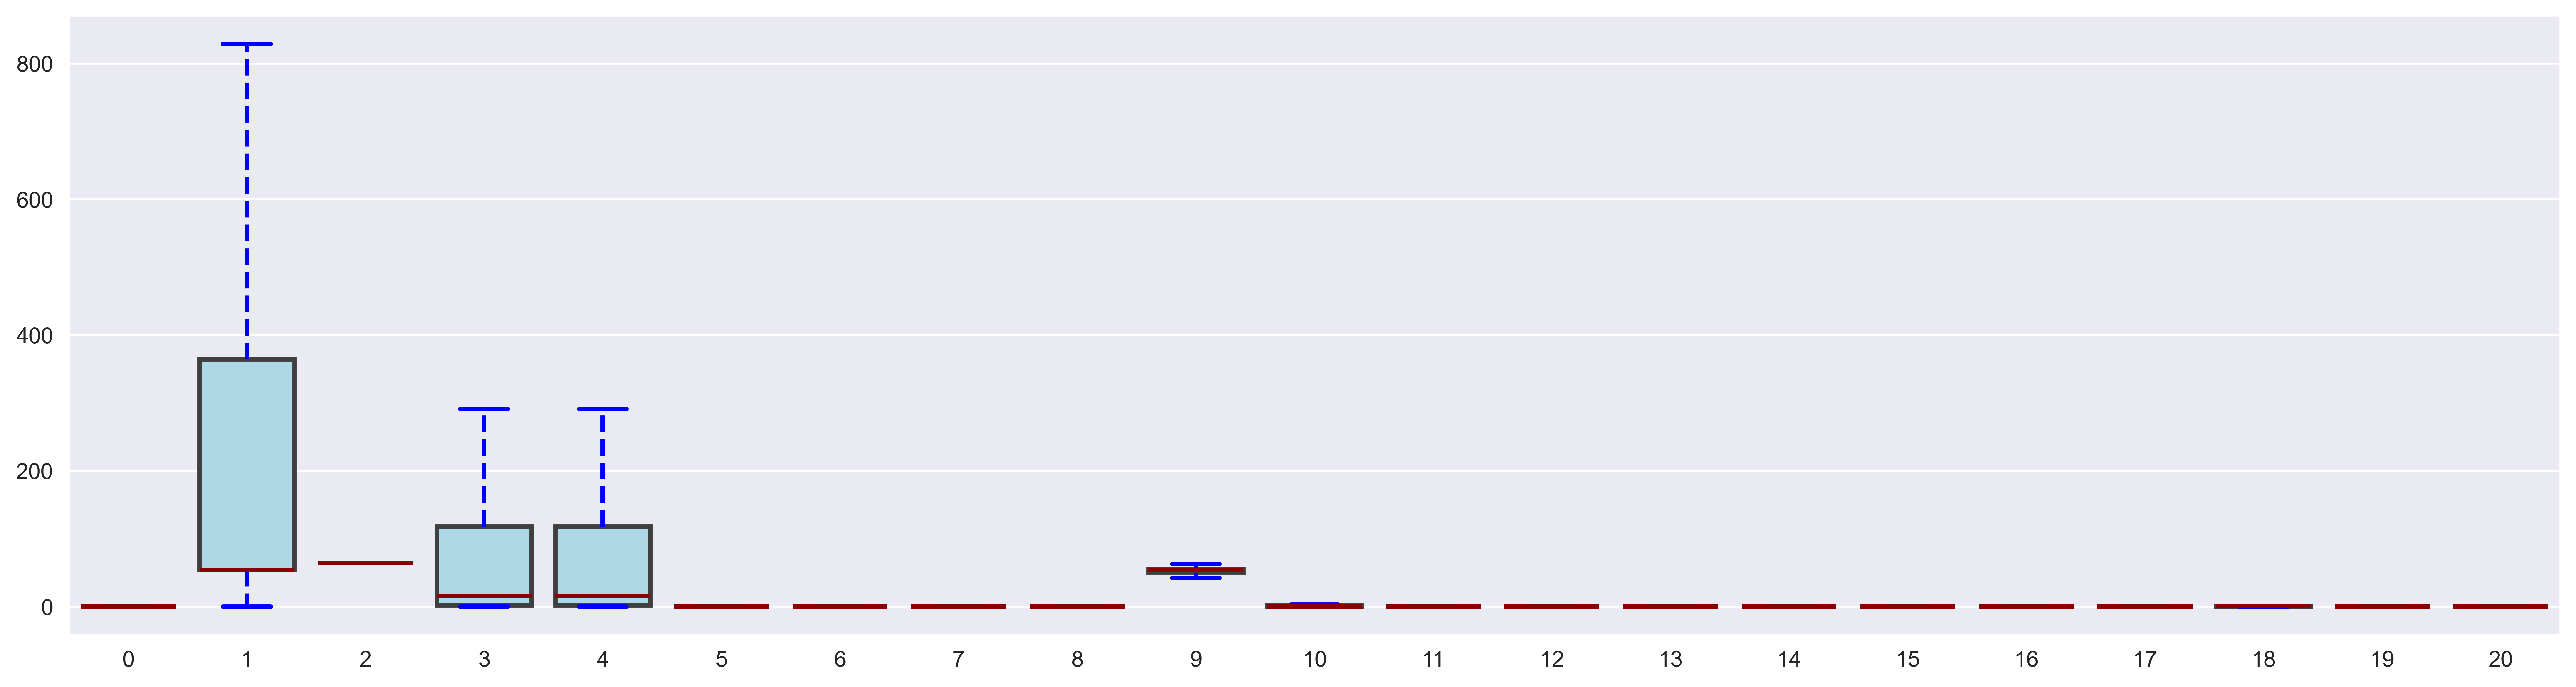

In [9]:
plt.figure(figsize=(20, 5), dpi=500)

sns.boxplot(
    data=df.select(cs.numeric()),#numeric columns only
    showfliers=False,  # hide extreme outliers
    boxprops=dict(facecolor="lightblue", linewidth=2),  # box styling
    whiskerprops=dict(color="blue", linewidth=2, linestyle="--"),
    medianprops=dict(color="darkred", linewidth=2),
    capprops=dict(color="blue", linewidth=2),
    # gap=1.5
)

plt.show()

In [10]:
df[[col for i, col in enumerate(df.columns) if i in [1, 3, 4, 9]]].describe()

statistic,header_size,overall_rate,src_rate,max_value
str,f64,f64,f64,f64
"""count""",938583.0,938583.0,938583.0,938583.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",101813.423375,9163.49561,9163.49561,177.16136
"""std""",1.8014e6,100180.600226,100180.600226,515.425327
"""min""",0.0,0.0,0.0,42.0
"""25%""",54.0,2.077074,2.077074,50.0
"""50%""",54.0,15.703769,15.703769,54.0
"""75%""",364.0,117.774989,117.774989,55.14
"""max""",3.3111737e8,7.340032e6,7.340032e6,30329.2


In [11]:
ScaledFeatures =  StandardScaler().fit_transform(df.select(cs.numeric()))
df = pl.concat(items = [pl.DataFrame(ScaledFeatures , schema = df.select(cs.numeric()).columns) , df.select("label")] ,  how="horizontal")

In [12]:
#feature selection 
selector = SelectKBest(score_func=f_classif, k=10)

selector.fit(df.select(cs.numeric()), df["label"])

selected_indices = selector.get_support(indices=True)
print(selected_indices , len(selected_indices),"features")
selected_features = [df.select(cs.numeric()).columns[i] for i in selected_indices]
print("\nSelected features: \n", selected_features)

[ 7  8  9 10 11 15 17 18 19 20] 10 features

Selected features: 
 ['urg_packets', 'rst_packets', 'max_value', 'value_covariance', 'fin_flags', 'ack_flags', 'protocol_https', 'protocol_tcp', 'protocol_udp', 'protocol_icmp']


In [13]:
# not as we did in phase 1 , we will be testing undersampling and oversampling, 
# validated my idea by generative pre-trained transformers

"""You're dealing with a pretty classic **class imbalance problem**, especially with `"ddos"` being massively overrepresented and `"benigntraffic"`, `"mitm"`, and `"recon"` heavily underrepresented.

Here's a breakdown of your idea, and some suggestions:

---

### ✅ Your Plan (Under + Over Sampling):
Using **undersampling on the majority ("ddos")** and then **oversampling the minority classes** is totally reasonable and commonly done. Here's how it might work:

#### Step-by-step version of your plan:
1. **Undersample "ddos"** to reduce its impact.
2. **Oversample "benigntraffic", "mitm", "recon"**, and maybe even "mirai" to get a more balanced dataset.
3. **Possibly leave "dos" as is**, or slightly adjust it.

---

### 🧠 Tips on Executing It:

#### 1. ⚖️ **Target Balance Strategy**
Decide your final desired sample size per class. Example ideas:
- Match to the size of "mirai" (~50K)
- Or go a bit lower to reduce training size, say ~30K per class
- Avoid exact balance — slight randomness can help generalization

#### 2. 🧹 **Undersampling "ddos"**
You can randomly select ~30K–50K rows from "ddos" (from 687K). Make sure to **shuffle** before picking.

#### 3. 🔁 **Oversampling Minorities**
Use techniques like:
- **Random Oversampling** (e.g., simple duplication)
- **SMOTE/ADASYN** (synthetic data generation, if the features support it — i.e., numeric and continuous)

> Note: SMOTE doesn’t work well with categorical data unless encoded carefully.

#### 4. 🧪 **Be Careful with Oversampling**
If you're evaluating on the same dataset, make sure not to **leak duplicated synthetic samples into your validation set** — only oversample in the training split.

---

### ⚖️ Alternative: Use Class Weights
If you're using tree-based models (like XGBoost, LightGBM) or neural nets, consider using **class weighting** instead. It avoids changing the actual data and simply adjusts the cost of misclassification.

---

### 👀 Example Target Distribution
| Label          | Target Count |
|----------------|--------------|
| ddos           | 30,000       |
| benigntraffic  | 30,000       |
| mitm           | 30,000       |
| mirai          | 30,000       |
| recon          | 30,000       |
| dos            | 30,000       |

You could tune this depending on whether you want full balance or slight realism.

---

### 📦 TL;DR
- Your under+over strategy is solid.
- Make sure not to leak synthetic samples into validation/test.
- Consider class weights as a simpler alternative if supported.
- Don’t overdo oversampling — can lead to overfitting if minority class is too tiny.

Would you like help with writing some code to implement this in Python (e.g., using `pandas`, `sklearn`, `imbalanced-learn`)?"""

'You\'re dealing with a pretty classic **class imbalance problem**, especially with `"ddos"` being massively overrepresented and `"benigntraffic"`, `"mitm"`, and `"recon"` heavily underrepresented.\n\nHere\'s a breakdown of your idea, and some suggestions:\n\n---\n\n### ✅ Your Plan (Under + Over Sampling):\nUsing **undersampling on the majority ("ddos")** and then **oversampling the minority classes** is totally reasonable and commonly done. Here\'s how it might work:\n\n#### Step-by-step version of your plan:\n1. **Undersample "ddos"** to reduce its impact.\n2. **Oversample "benigntraffic", "mitm", "recon"**, and maybe even "mirai" to get a more balanced dataset.\n3. **Possibly leave "dos" as is**, or slightly adjust it.\n\n---\n\n### 🧠 Tips on Executing It:\n\n#### 1. ⚖️ **Target Balance Strategy**\nDecide your final desired sample size per class. Example ideas:\n- Match to the size of "mirai" (~50K)\n- Or go a bit lower to reduce training size, say ~30K per class\n- Avoid exact bala

In [26]:
# Just a tester

X_train, X_test, y_train, y_test = train_test_split(df.select(selected_features), df["label"], test_size=0.25, random_state=42)


rf_model = RandomForestClassifier(random_state=42, class_weight="balanced" , n_jobs=-1)  # class_weight="balanced" helps with imbalance
rf_model.fit(X_train, y_train)


y_pred = rf_model.predict(X_test)


print("\nClassification Report:\n")
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))


Classification Report:



,benigntraffic,ddos,dos,mirai,mitm,recon,accuracy,macro avg,weighted avg
precision,0.763720,0.943871,0.318572,0.995863,0.777108,0.666097,0.643774,0.744205,0.830171
recall,0.922734,0.558225,0.860675,0.990203,0.578475,0.481481,0.643774,0.731966,0.643774
f1-score,0.835731,0.701543,0.465021,0.993025,0.663239,0.558939,0.643774,0.702916,0.678573
support,5384.000000,171619.000000,41091.000000,13371.000000,1561.000000,1620.000000,0.643774,234646.000000,234646.000000


# Dimensionality Reduction

In [21]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import time

# Step 1: Reduce dimensions with PCA first (big speed improvement)
start_time = time.time()
pca = PCA(n_components=min(50, len(df[selected_features].columns)))
pca_result = pca.fit_transform(df[selected_features])
print(f"PCA preprocessing: {time.time() - start_time:.2f} seconds")

# Step 2: Apply t-SNE with optimized parameters
start_time = time.time()
tsne = TSNE(
    n_components=2,
    random_state=0,
    method='barnes_hut',  # Faster algorithm
    n_iter=750,           # Reduced from default 1000
    learning_rate='auto', # Automatic learning rate since sklearn 1.2
    perplexity=min(30, len(df) - 1)  # Adjust based on dataset size
)
tsne_data = tsne.fit_transform(pca_result)
print(f"t-SNE completed in {time.time() - start_time:.2f} seconds")
print(f"Output shape: {tsne_data.shape}")

KeyboardInterrupt: 

In [ ]:
colors_map = {
    "ddos": "red",
    "recon": "blue",
    "benigntraffic": "green",
    "mitm": "orange",
    "dos": "purple",
    "mirai": "cyan"
}

plt.scatter(data=embedding, c=df["target"].replace(colors_map))
plt.title("t-SNE Projection")
plt.show()

# Classes Balancing